In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os, csv, json, itertools
import pandas as pd
import scipy.optimize as sp

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl

%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/aux_funcs.py
%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/RSRG.py
%run /home/guaravtenkila/Disorder_sims/Ising_RSRG/RSRG_class.py

In [3]:
run_dir = "large_inst_runs/"
log_file = pd.read_csv(run_dir+"log_file.csv")
ts_list = np.array(log_file['ts'].tolist())
#misc_notes = log_file['misc'].tolist()
log_file


,L,steps,a,b,w,n_runs,misc,ts
0,60,3580,0.1,0.105,4.83,640,"no bond pruning, storing bonds <omega=15",684413316048.31.0
1,60,3580,0.1,0.105,4.86,640,"no bond pruning, storing bonds <omega=15",684694546048.61.0
2,60,3580,0.1,0.105,4.80,640,"no bond pruning, storing bonds <omega=15",684365176048.01.0
3,60,3580,0.1,0.105,4.89,640,"no bond pruning, storing bonds <omega=15",685621106048.91.0
4,60,3580,0.1,0.105,4.95,640,"no bond pruning, storing bonds <omega=15",686333046049.51.0
5,60,3580,0.1,0.105,4.98,640,"no bond pruning, storing bonds <omega=15",686519036049.8000000000000041.0
6,60,3580,0.1,0.105,4.92,640,"no bond pruning, storing bonds <omega=15",686028736049.21.0
7,60,3580,0.1,0.105,5.04,640,"no bond pruning, storing bonds <omega=15",686788596050.41.0
8,60,3580,0.1,0.105,5.07,640,"no bond pruning, storing bonds <omega=15",686798126050.71.0
9,60,3580,0.1,0.105,5.01,640,"no bond pruning, storing bonds <omega=15",686692266050.0999999999999941.0


In [5]:
def output_reader(measure_list, fname):
    J_dist_dict = [{} for _ in range(len(measure_list))]
    h_dist_dict = [{} for _ in range(len(measure_list))]

    #In1629_J_m3571
    C = 0
    with open(fname, 'r') as reader:
        next(reader)
        for line in reader:
            C+=1
            marker_end = line.find('[')
            inst_num = int(line[2:6])
            coupling_type = line[7:8]
            measure_ind = np.where(measure_list==int(line[10:marker_end]))[0][0]
            try:
                couplings = np.array(json.loads(line[marker_end:]))
            except:
                print("Corrupted file")
            if coupling_type == 'h':
                h_dist_dict[measure_ind][inst_num] = couplings
            elif coupling_type == 'J':
                J_dist_dict[measure_ind][inst_num] = couplings
    
    return [h_dist_dict, J_dist_dict]

def unpack_dictionaries(file_out, measure_list):
    h_dist_dict, J_dist_dict = file_out
    h_dist_list, J_dist_list = [], []
    
    for i in range(len(measure_list)):
        h_dist_list.append(np.concatenate(tuple(h_dist_dict[i].values())))
        J_dist_list.append(np.concatenate(tuple(J_dist_dict[i].values())))
        
    return h_dist_list, J_dist_list

In [125]:
log_file = pd.read_csv(run_dir+"log_file.csv")
ts_list = np.array(log_file['ts'].tolist())
ts = str(ts_list[10])

with open(run_dir+"LIsing_2D_input_"+ts+".pkl", "rb") as fp:   
    input_dict = pickle.load(fp)
        
with open(run_dir+"LIsing_2D_clusters_"+ts+".pkl", "rb") as fp:   
    clust_list_final = pickle.load(fp)
    
measure_list = input_dict['measure_list']
h_dist_dict, J_dist_dict = output_reader(measure_list, run_dir+"LIsing_2D_output_"+ts+".txt")


h_dist_list,J_dist_list = [], []
for i in range(len(measure_list)):
    h_dist_list.append(np.concatenate(tuple(h_dist_dict[i].values())))
    J_dist_list.append(np.concatenate(tuple(J_dist_dict[i].values())))

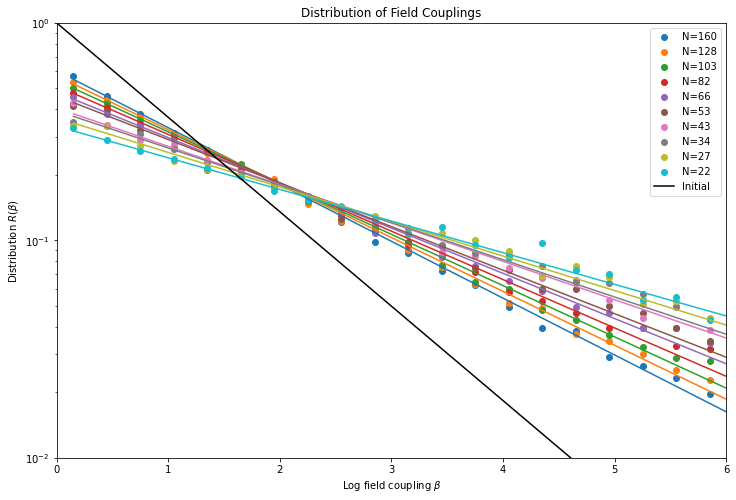

In [98]:
measure_list = input_dict['measure_list']
L = input_dict['L']
spins_left = L*L - measure_list
n_runs = input_dict['n_runs']
n_bins_h = 40
width_list = []
plt.figure(figsize=(12, 8))

for i,step in enumerate(spins_left[:-1]): 
    n,bins = np.histogram(h_dist_list[i], density=True, bins = n_bins_h, range=(0,12))
    width = bins[1]-bins[0]
    x = (bins[1:]-width/2)
    y = n
    popt, pcov = curve_fit(exponential_dist_norm, x[1:30], y[1:30])
    if i%2==0: 
        plt.scatter(x, y, label="N="+str(step), marker='o')
        plt.plot(x, exponential_dist_norm(x, *popt))
        #print(popt)
    width_list.append(1/popt[0])

#plt.yscale('log')
#plt.xlim(0, 6)
#plt.ylim(1e-1, 1)

x_temp = np.linspace(0, 12)
plt.plot(x_temp, np.exp(-x_temp), c='k', label='Initial')

plt.xlabel(r"Log field coupling $\beta$")
plt.ylabel(r"Distribution $R(\beta)$")
plt.title("Distribution of Field Couplings")
plt.yscale('log')
plt.xlim(0, 6)
plt.ylim(1e-2, 1)
plt.legend()

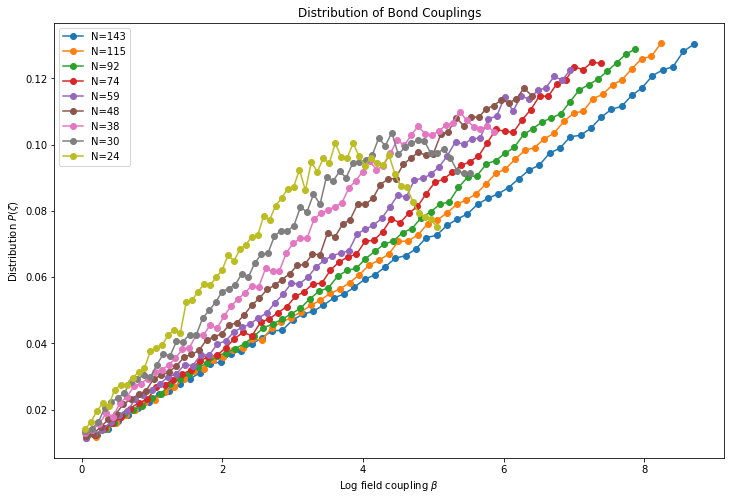

In [99]:
measure_list = input_dict['measure_list']
n_runs = input_dict['n_runs']
n_bins_J = 60
#width_list = []
plt.figure(figsize=(12, 8))

for i,step in enumerate(spins_left[:-1]): 
    n,bins = np.histogram(J_dist_list[i], density=True, bins = n_bins_J)
    width = bins[1]-bins[0]
    x = (bins[1:]-width/2)/width_list[i]
    y = n
    if not i%2==0: plt.plot(x, y, label="N="+str(step), marker='o')

    #popt, pcov = curve_fit(exponential_dist_norm, x[:20], y[:20])
    #plt.plot(x, exponential_dist_norm(x, *popt))
    #width_list.append(1/popt[0])


#plt.xlim(0, 6)
#plt.ylim(1e-1, 1)

plt.xlabel(r"Log field coupling $\beta$")
plt.ylabel(r"Distribution $P(\zeta)$")
plt.title("Distribution of Bond Couplings")

plt.legend()

[0.30608669 7.61569994]


Text(1600, 2, '$\\psi=$0.612')

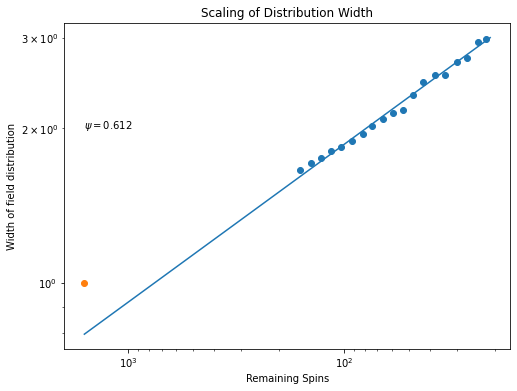

In [100]:
plt.figure(figsize=(8, 6))
plt.scatter(spins_left[:-1], width_list)
x = spins_left[:-1]

popt, pcov = curve_fit(power_law_scale, x[:], width_list[:])


x = L*L - np.arange(L*L - 20)
plt.plot(x, power_law_scale(x, *popt))
plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')
print(popt)
plt.scatter([L*L], [1])


plt.title("Scaling of Distribution Width")
plt.xlabel("Remaining Spins")
plt.ylabel("Width of field distribution")
#Note: Improve fitting on the distribution, I think that's where your issue is coming from
plt.text(s=r"$\psi=$"+str(round(2*popt[0], 3)), x= L*L, y = 2)

In [32]:
def linear_fit(x, a ,b):
    return x*a + b


L = 40
fixed_length_slice = log_file[log_file['L']==L]
ts_list = np.array(fixed_length_slice['ts'].tolist())
misc_notes = fixed_length_slice['misc'].tolist()

free_spins_comp = []
intercept_list_comp = []
slope_list_comp = []
marker_list = []

for index,ts in enumerate(ts_list):

    with open(run_dir+"LIsing_2D_input_"+str(ts)+".pkl", "rb") as fp:   
        input_dict = pickle.load(fp)
    
    measure_list = input_dict['measure_list']
    h_dist_list, J_dist_list = output_reader(measure_list, run_dir+"LIsing_2D_output_"+str(ts)+".txt")
    
    spins_left = L*L - measure_list
    
    intercept_list = []
    slope_list = []
    free_spins = []
    
    for i,step in enumerate(spins_left[:-1]): 

        n,bins = np.histogram(h_dist_list[i], density=True, bins = n_bins_h, range=(0,12))
        width = bins[1]-bins[0]
        x = (bins[1:]-width/2)
        y = n
        popt, pcov = curve_fit(exponential_dist_norm, x[1:30], y[1:30])
        width = 1/popt[0]

        n,bins = np.histogram(J_dist_list[i], density=True, bins = n_bins_J)
        width = bins[1]-bins[0]
        x = (bins[1:]-width/2)/width
        y = n
        
        popt, pcov = curve_fit(linear_fit, x[1:], y[1:])
        slope_list.append(popt[0]*len(h_dist_list[i]))
        intercept_list.append(popt[1]*len(h_dist_list[i]))
        free_spins.append(step)
        
    free_spins_comp.append(free_spins)
    slope_list_comp.append(slope_list)
    intercept_list_comp.append(intercept_list)


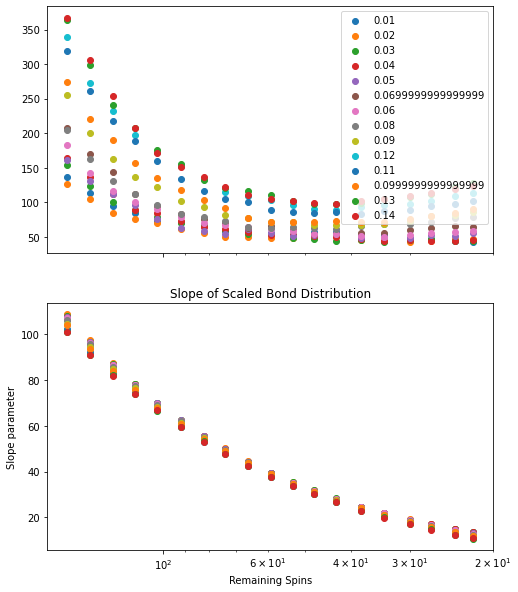

In [33]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
w_vals = fixed_length_slice['a'].tolist()
#plt.figure(figsize=(8, 6))

for index,ts in enumerate(ts_list):
    #if marker_list[index] != 'x': continue
    axs[0].scatter(free_spins_comp[index], intercept_list_comp[index], label=str(w_vals[index]))
    axs[1].scatter(free_spins_comp[index], slope_list_comp[index])
    #plt.scatter(free_spins_comp[index], slope_list_comp[index], label="Width="+str(round(w_vals[index],2)))
plt.gca().invert_xaxis()
plt.xscale('log')
#plt.yscale('log')
plt.title("Slope of Scaled Bond Distribution")
plt.xlabel("Remaining Spins")
plt.ylabel("Slope parameter")
#plt.scatter(L*L, 0.1, marker='^')
axs[0].legend()

In [568]:
def random_lin_dist_width(a, b, w, n_samples):
    x = Symbol('x')
    X = ContinuousRV(x, (a+b*x)/(a*w + b*w**2/2), Interval(0, w))
    return sample(X, size=(n_samples))

n,bins = np.histogram(random_lin_dist_width(0.1, 0.105, 3, 5000), density=True, bins = n_bins_J)
width = bins[1]-bins[0]
x = (bins[1:]-width/2)
y = n

array([0.13673597, 0.12849402])

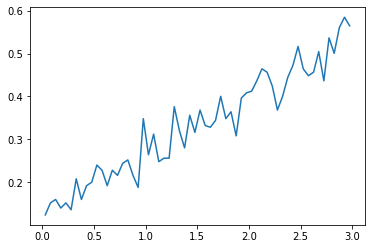

In [569]:
popt, pcov = curve_fit(linear_fit, x[1:], y[1:])
popt
plt.plot(x, y)
popt

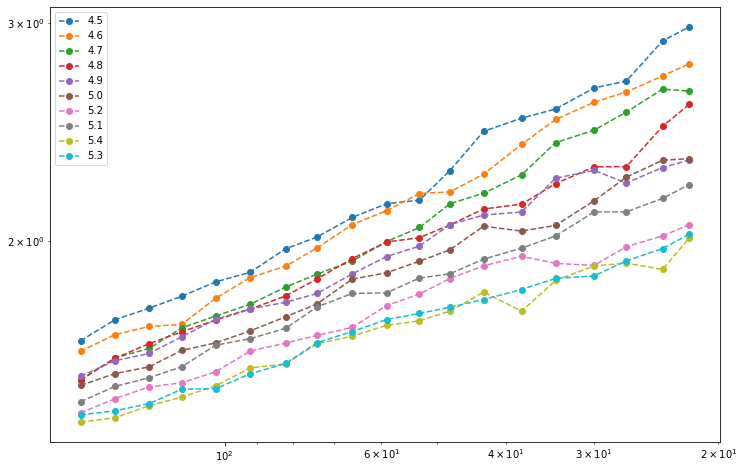

In [105]:
plt.figure(figsize=(12, 8))
scaling_index = []
param_list = []

for index, ts in enumerate(ts_list[10:20]):
    with open(run_dir+"LIsing_2D_input_"+str(ts)+".pkl", "rb") as fp:   
        input_dict = pickle.load(fp)
        
    measure_list = input_dict['measure_list']
    
    h_dist_list, J_dist_list = output_reader(measure_list, run_dir+"LIsing_2D_output_"+str(ts)+".txt")
    
    L = input_dict['L']
    spins_left = L*L - measure_list
    n_runs = input_dict['n_runs']
    n_bins_h = 50
    width_list = []
    for i,step in enumerate(spins_left[:-1]): 
        n,bins = np.histogram(h_dist_list[i], density=True, bins = n_bins_h, range=(0,12))
        width = bins[1]-bins[0]
        x = (bins[1:]-width/2)
        y = n
        popt, pcov = curve_fit(exponential_dist_norm, x[1:10], y[1:10])
        width_list.append(1/popt[0])
    
    plt.plot(spins_left[:-1], width_list, label=input_dict['w'], linestyle='--', marker='o')
    x = spins_left[:-1]
    popt, pcov = curve_fit(power_law_scale, x[:], width_list[:])
    param_list.append(input_dict['w'])
    scaling_index.append(popt[0])
    
plt.legend()
plt.gca().invert_xaxis()
plt.xscale('log')
plt.yscale('log')

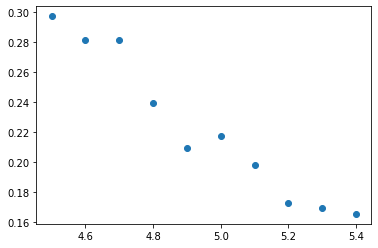

In [106]:
plt.scatter(param_list, scaling_index)

In [8]:
L = 60
fixed_length_slice = log_file[log_file['L']==L]
ts_list = fixed_length_slice['ts'].tolist()
misc_notes = fixed_length_slice['misc'].tolist()

w_vals = fixed_length_slice['w'].tolist()#fixed_length_slice['w'].tolist()
largest_clust_size = []
var_lcs = [] 
marker_list = []
c_list = []
c_dict = {40: 'magenta', 60:'red', 50:'blue', 100:'green'}

for index, ts in enumerate(ts_list):

    with open(run_dir+"LIsing_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
        clust_list_final = pickle.load(fp)

    #print(input_dict)
    clust_dict_list, reverse_dict_list = [], []
    
    largest_clust_list  = []
    for core_pair in clust_list_final:
        clust_list_temp = core_pair[0] 
        reverse_list_temp = core_pair[1]
        clust_dict_list+=clust_list_temp
        reverse_dict_list+=reverse_list_temp
        #largest_clust_list+=[max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_list_temp]

    largest_clust_list = np.array([max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_dict_list])
    
    largest_clust_list = np.array(largest_clust_list)
    largest_clust_size.append(largest_clust_list.mean()/L**2)
    var_lcs.append(largest_clust_list.std()/L**2)
    if str(6) in misc_notes[index]: m_type, c_type = 'o', 'red'
    elif str(10) in misc_notes[index]: m_type, c_type = 'x', 'blue'
    elif str(30) in misc_notes[index]: m_type, c_type = 's', 'orange'
    elif "no" in misc_notes[index]: m_type, c_type = '^', 'black'
    marker_list.append(m_type)
    c_list.append(c_type)

Text(0.5, 1.0, 'Largest Spin Cluster and Variance in Size')

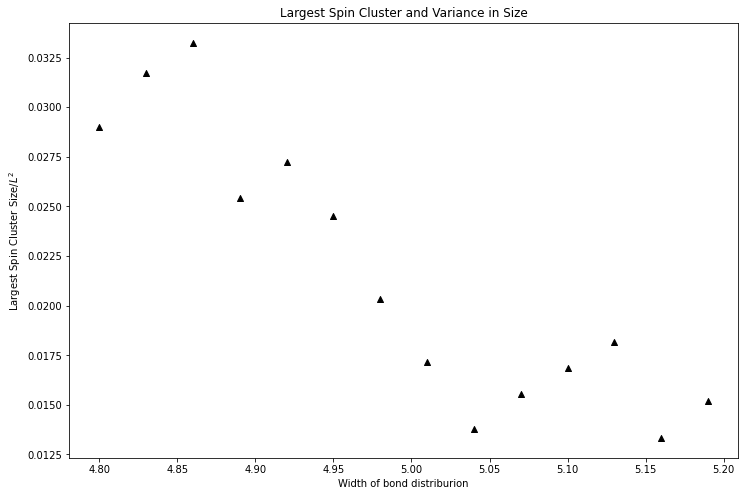

In [9]:
#plt.errorbar(w_vals, largest_clust_size, yerr=var_lcs, marker='o', linestyle='')
plt.figure(figsize=(12, 8))
for i, w in enumerate(w_vals):
    plt.scatter(w, largest_clust_size[i], marker=marker_list[i], c=c_list[i])
plt.ylabel("Largest Spin Cluster Size/$L^2$")
plt.xlabel("Width of bond distriburion")
plt.title("Largest Spin Cluster and Variance in Size")


In [109]:
L_list = [40, 50]
c_dict = {40: 'magenta', 50:'red', 60:'blue', 70:'green'}



w_vals_comp = []
lcs_comp = []
marker_comp = []

for L in L_list:
    log_file = pd.read_csv(run_dir+"log_file.csv")
    fixed_length_slice = log_file[lambda df: (df['L'] == L)]
    ts_list = fixed_length_slice['ts'].tolist()
    misc_notes = fixed_length_slice['misc'].tolist()

    w_vals = fixed_length_slice['a'].tolist()
    largest_clust_size = []
    w_list = []
    var_lcs = [] 
    c_list = []
    m_list = []
    

    for index, ts in enumerate(ts_list):
        
        if str(30) in misc_notes[index]: continue#m_type, c_type = 'o', 'red'
        elif "no" in misc_notes[index]: m_type, c_type = 'x', 'blue'
        m_list.append(m_type)
        
        with open(run_dir+"LIsing_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list = [], []

        for core_pair in clust_list_final:
            clust_list_temp  = core_pair[0] 
            reverse_list_temp = core_pair[1]
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp

        largest_clust_list = np.array([max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_dict_list])

        largest_clust_size.append(largest_clust_list.mean()/L**2)
        var_lcs.append(largest_clust_list.std()/L**2)
        w_list.append(w_vals[index])
        #c_list.append(c_dict[L])
    
    w_vals_comp.append(w_list)
    lcs_comp.append(largest_clust_size)
    marker_comp.append(m_list)
    

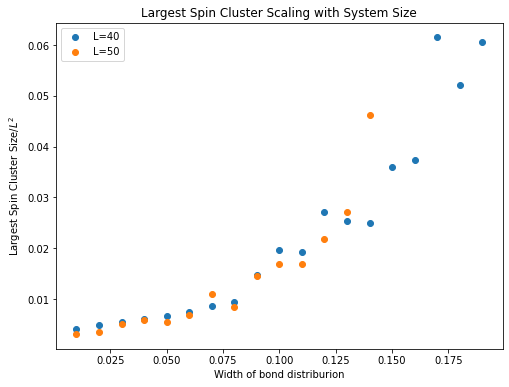

In [110]:
plt.figure(figsize=(8, 6))

for i, L in enumerate(L_list):
    #for ind, w in enumerate(w_vals_comp[i]):
    #    plt.scatter(w, lcs_comp[i][ind], c=c_dict[L], marker=marker_comp[i][ind])
    plt.scatter(w_vals_comp[i], lcs_comp[i], label='L='+str(L))
plt.ylabel("Largest Spin Cluster Size/$L^2$")
plt.xlabel("Width of bond distriburion")
plt.title("Largest Spin Cluster Scaling with System Size")
plt.legend()

#plt.ylim(0, 0.2)

In [609]:
def check_percolation(clust_dict, L, width):
    end_point = int(L/2)
    for y1 in range(L):
        for y1_width in range(-width, width+1):
            for y2 in range(L):
                for y2_width in range(-width, width+1):
                    start_ind = index_map(y1_width%L, y1, L)
                    end_index = index_map((end_point+y2_width)%L, y2, L)
                    if (clust_dict[start_ind] == clust_dict[end_index]): 
                        return True
    return False
        

Text(0.5, 1.0, 'Percolation Transition')

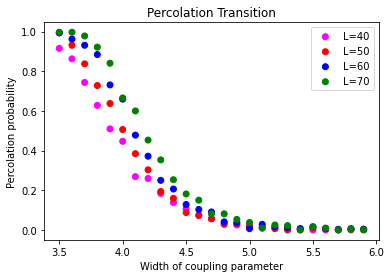

In [610]:
for L in [40, 50, 60, 70]:
    fixed_length_slice = log_file[lambda df: (df['L'] == L) & (df['a']==0.1)]
    ts_list = fixed_length_slice['ts'].tolist()
    w_vals = fixed_length_slice['w'].tolist()
    misc_notes = fixed_length_slice['misc'].tolist()
    p_perc_clust = []
    c_list = []
    w_list = []
    #color_dict = {50:'blue', 60:'red', 40:'green'}

    for index, ts in enumerate(ts_list):
        if not "no" in misc_notes[index]: continue
        with open(run_dir+"LIsing_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list = [], []
        perc_cluster = []

        for core_pair in clust_list_final:
            clust_list_temp = core_pair[0]
            reverse_list_temp = core_pair[1]
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp

        perc_prob_temp = np.array([check_percolation(clust, L, 2) for clust in clust_dict_list])

        p_perc_clust.append(perc_prob_temp.mean())
        c_list.append(c_dict[L])
        w_list.append(w_vals[index])
   
    plt.scatter(w_list, p_perc_clust, c=c_list, label="L="+str(L))
    

plt.legend()
plt.ylabel("Percolation probability")
plt.xlabel("Width of coupling parameter")
plt.title("Percolation Transition")

In [15]:
def extract_cluster_sizes(reverse_dict_list):
    clust_size_list = []
    for i, reverse_dict in enumerate(reverse_dict_list):
        for cluster in reverse_dict.values():
            if cluster is None: continue
            clust_size_list.append(len(cluster))
    return np.array(clust_size_list)

def get_distribution_curvature(hist, bin_edges):
    width = bin_edges[1]-bin_edges[0]
    x = bin_edges[1:]-width/2   #Realigning x-axis
    
    cdf = np.cumsum(hist)        #Cumulative distribution function for pdf given by histogram
    smooth = gaussian_filter1d(cdf, 1)       #Gaussian smoothing of cdf function in order to take derivative
    second_der = np.gradient(np.gradient(smooth))
    a = np.diff(np.sign(np.diff(second_der))).nonzero()[0] + 1    #Checking where there is a jump in cdf
    
    infl_size = second_der[a[-2]]-second_der[a[-1]]            #Size of the last jump (empirically determined)
    
    return infl_size

In [16]:
L_list = [40,50,60,70]
clust_size_list_comp = []
clust_size_list_bdry_comp = []
w_vals_comp = []
run_dir = "run_set_6/"
log_file = pd.read_csv(run_dir+"log_file.csv")

for L in L_list:
    fixed_length_slice = log_file[lambda df: (df['L'] == L)]
    ts_list = fixed_length_slice['ts'].tolist()

    w_vals = fixed_length_slice['w'].tolist()
    clust_size_list = []
    clust_dict_list_bdry = []
    

    for index, ts in enumerate(ts_list):

        with open(run_dir+"LIsing_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list = [], []

        for core_pair in clust_list_final:
            clust_list_temp = core_pair[0] 
            reverse_list_temp = core_pair[1]
            clust_dict_list+=clust_list_temp
            reverse_dict_list+=reverse_list_temp
        
        clust_sizes = extract_cluster_sizes(reverse_dict_list)
        #List of sizes of all clusters normalized to system size       
        clust_size_list.append(clust_sizes[clust_sizes!=1]/L**2)

    w_vals_comp.append(w_vals)
    clust_size_list_comp.append(clust_size_list)

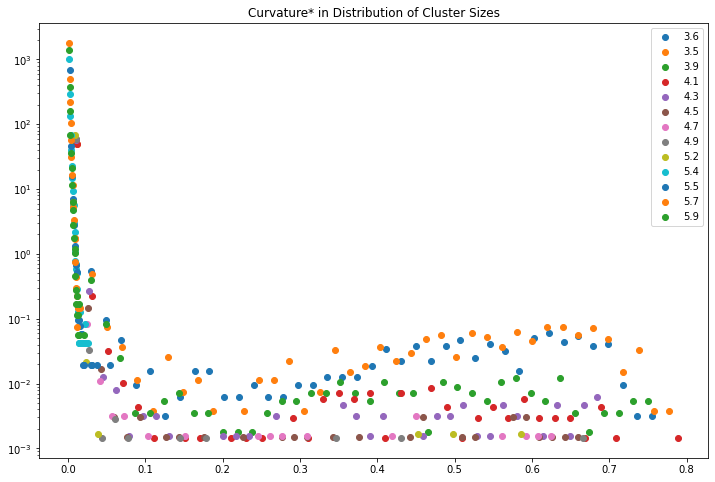

In [17]:
from scipy.ndimage import gaussian_filter1d
import scipy.signal as sg

fig, ax0 = plt.subplots(figsize=(12, 8))

c_dict = {40:'red', 70:'blue', 60:'green', 80:'cyan', 50:'orange', 100:'magenta', 85:'orange'}
cmap_type = {40:'Greens', 60:'Blues', 50:'Reds', 70:'Greys'}
for ind, L in enumerate(L_list[-1:]):
    curve_check = []
    mean_clust_size = []
    cdf_max = []
    for index, w in enumerate(w_vals_comp[ind]):
        if not index%2==0: continue
        #if not index==0: continue    
        cmap_L = cm.get_cmap(cmap_type[L])
        norm = plt.Normalize(2, 3)
        hist, bin_edges = np.histogram(clust_size_list_comp[ind][index], density=True, bins=40)
        width = bin_edges[1]-bin_edges[0]
        x = bin_edges[1:]-width/2
        ax0.scatter(x, hist, label=str(w))
        
        infl_size = get_distribution_curvature(hist, bin_edges)
        curve_check.append(infl_size)

        #Attempt at doing statistics on cluster sizes
        """
        cs_list = clust_size_list_comp[ind][index]
        cs_list = cs_list[cs_list>(0.8*L/(L*L))]
        mean_clust_size.append(np.median(cs_list))
        """
        
        #Attempt at checking concavity of the distribution to identify transition
        """
        raw = np.log(hist)[5:]
        ax0.plot(raw, color=cmap_L(norm(w)))
        smooth = gaussian_filter1d(raw, 1)
        ax0.plot(smooth, color=cmap_L(norm(w)), linestyle='--')
        smooth_d1 = np.gradient(smooth[smooth>-4])
        curve_check.append(np.sum(smooth_d1))
        """
        
    
    #ax0.plot(w_vals_comp[ind], mean_clust_size, c=c_dict[L], marker='o')
    #ax0.scatter(w_vals_comp[ind], cdf_max, c=c_dict[L], marker='o')
    #ax0.scatter(w_vals_comp[ind], curve_check, c=c_dict[L], marker='o', label="L="+str(L))
    #fig, ax = plt.subplots(figsize=(6, 1))
    #fig.subplots_adjust(bottom=0.5)
    #cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap_L,
    #                            norm=norm,
    #                            orientation='horizontal')
    
ax0.set_title("Curvature* in Distribution of Cluster Sizes")
ax0.axhline(y=0)
#ax0.xscale('log')
ax0.set_yscale('log')
plt.legend()

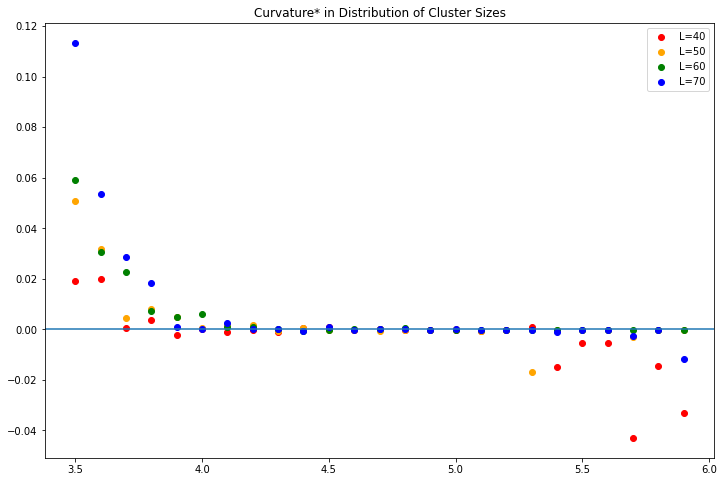

In [18]:
from scipy.ndimage import gaussian_filter1d
import scipy.signal as sg

fig, ax0 = plt.subplots(figsize=(12, 8))

for ind, L in enumerate(L_list):
    curve_check = []
    mean_clust_size = []
    cdf_max = []
    for index, w in enumerate(w_vals_comp[ind]):
        #if not index%3==0: continue
        #if not index==0: continue    
        cmap_L = cm.get_cmap(cmap_type[L])
        norm = plt.Normalize(2, 3)
        hist, bin_edges = np.histogram(clust_size_list_comp[ind][index], density=True, bins=40)
        width = bin_edges[1]-bin_edges[0]
        x = bin_edges[1:]-width/2
        #ax0.scatter(x, hist, label=str(w))
        
        infl_size = get_distribution_curvature(hist, bin_edges)
        curve_check.append(infl_size)

        #Attempt at doing statistics on cluster sizes
        """
        cs_list = clust_size_list_comp[ind][index]
        cs_list = cs_list[cs_list>(0.8*L/(L*L))]
        mean_clust_size.append(np.median(cs_list))
        """
        
        #Attempt at checking concavity of the distribution to identify transition
        """
        raw = np.log(hist)[5:]
        ax0.plot(raw, color=cmap_L(norm(w)))
        smooth = gaussian_filter1d(raw, 1)
        ax0.plot(smooth, color=cmap_L(norm(w)), linestyle='--')
        smooth_d1 = np.gradient(smooth[smooth>-4])
        curve_check.append(np.sum(smooth_d1))
        """
        
    
    #ax0.plot(w_vals_comp[ind], mean_clust_size, c=c_dict[L], marker='o')
    #ax0.scatter(w_vals_comp[ind], cdf_max, c=c_dict[L], marker='o')
    ax0.scatter(w_vals_comp[ind], curve_check, c=c_dict[L], marker='o', label="L="+str(L))
    #fig, ax = plt.subplots(figsize=(6, 1))
    #fig.subplots_adjust(bottom=0.5)
    #cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap_L,
    #                            norm=norm,
    #                            orientation='horizontal')
    
ax0.set_title("Curvature* in Distribution of Cluster Sizes")
ax0.axhline(y=0)
#ax0.xscale('log')
#ax0.set_yscale('log')
plt.legend()

In [611]:
L_list = [40, 50, 60, 70]
c_dict = {40:'red', 50:'magenta', 60:'blue', 80:'green', 70:'orange'}


w_vals_comp = []
moment_array_comp = []

for L in L_list:
    log_file = pd.read_csv(run_dir+"log_file.csv")
    fixed_length_slice = log_file[lambda df: (df['L'] == L) & (df['a']==0.1)]
    ts_list = fixed_length_slice['ts'].tolist()

    w_vals = fixed_length_slice['w'].tolist()
    misc_notes = fixed_length_slice['misc'].tolist()
    mean_moment_list = []
    w_list = []

    for index, ts in enumerate(ts_list):
        if not "no" in misc_notes[index]: continue
        with open(run_dir+"LIsing_2D_clusters_"+str(ts)+".pkl", "rb") as fp:   
            clust_list_final = pickle.load(fp)

        #print(input_dict)
        clust_dict_list, reverse_dict_list = [], []
        moment_list_comp = []

        for core_pair in clust_list_final:
            moment_list_temp = core_pair[2]
            moment_list_comp+=moment_list_temp
        
        mean_moment_list.append(np.array(moment_list_comp).mean(axis=0))
        w_list.append(w_vals[index])
        
    w_vals_comp.append(w_list)
    moment_array_comp.append(mean_moment_list)

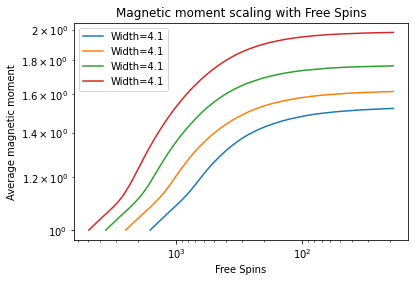

In [613]:
plt.figure(figsize=(6, 4))

for ind, L in enumerate(L_list):
    #if not L==40: continue
    for index, w in enumerate(w_vals_comp[ind]):
        if not index==6: continue
        y_data = moment_array_comp[ind][index]
        x_axis = L*L - np.arange(len(y_data))
        plt.plot(x_axis, y_data, label="Width="+str(w))

        
#popt, pcov = curve_fit(power_law_scale, x_axis[-100:], y_data[-100:])
#plt.plot(x_axis, power_law_scale(x_axis, *popt), linestyle='--')
#plt.text(s=r"$\overline{\mu}=N^{-%f}$" %popt[0], x=L*L, y = 3, size=15)
plt.title("Magnetic moment scaling with Free Spins")
plt.xlabel("Free Spins")
plt.ylabel("Average magnetic moment")
#print(popt)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.gca().invert_xaxis()



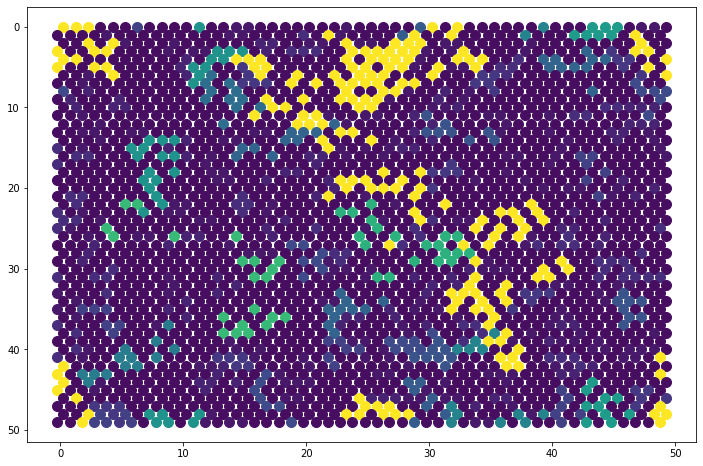

In [91]:
import matplotlib as mpl
import matplotlib.cm as cm

run_dir = "run_set_6/"
log_file = pd.read_csv(run_dir+"log_file.csv")
L = 50
ts_list = log_file['ts'].tolist()
ts = str(ts_list[34])


with open(run_dir+"LIsing_2D_clusters_"+ts+".pkl", "rb") as fp:   
    clust_list_final = pickle.load(fp)

plt.figure(figsize=(12, 8))
clust_dict = clust_list_final[1][0][0]
reverse_dict = clust_list_final[1][1][0]

norm = mpl.colors.Normalize(vmin=0, vmax=L*L/80)
cmap = 'viridis'#cm.hsv
m = cm.ScalarMappable(norm=norm, cmap=cmap)

for x in range(L):
    for y in range(L):
        
        site_ind = index_map(x, y, L)
        #if clust_dict[site_ind] == site_ind: c='blue'
        #else: 
        #    c = m.cmap(norm(len(reverse_dict[clust_dict[site_ind]])))
        c = m.cmap(norm(len(reverse_dict[clust_dict[site_ind]])))
        plt.scatter(y+(0.25*(-1)**(x%2)), x, color=c, s= 100)
        

plt.gca().invert_yaxis()

In [63]:
log_file[25:40]

,L,steps,a,b,w,n_runs,misc,ts
25,50,2480,0.1,0.105,3.5,320,"no bond pruning, storing bonds <omega=15",8541816352
26,50,2480,0.1,0.105,3.6,320,"no bond pruning, storing bonds <omega=15",8541839740
27,50,2480,0.1,0.105,3.7,320,"no bond pruning, storing bonds <omega=15",8541841274
28,50,2480,0.1,0.105,3.8,320,"no bond pruning, storing bonds <omega=15",8541842175
29,50,2480,0.1,0.105,3.9,320,"no bond pruning, storing bonds <omega=15",8541910436
30,50,2480,0.1,0.105,4.0,320,"no bond pruning, storing bonds <omega=15",8541911720
31,50,2480,0.1,0.105,4.1,320,"no bond pruning, storing bonds <omega=15",8541913763
32,50,2480,0.1,0.105,4.2,320,"no bond pruning, storing bonds <omega=15",8541949016
33,50,2480,0.1,0.105,4.3,320,"no bond pruning, storing bonds <omega=15",8541959478
34,50,2480,0.1,0.105,4.4,320,"no bond pruning, storing bonds <omega=15",8541971155


In [74]:
m.cmap(19)

(0.283091, 0.110553, 0.431554, 1.0)